# MOF Recommender System: Constructing a matrix with Henry coefficients from the Sparsity Matrix

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import seaborn as sns
from scipy import stats
import scipy

### Load in the Sparsity Matrix and other relevant files

In [2]:
material_gas_df = pd.read_csv('data/material_gas_dataframe_5.csv')
material_gas_df.set_index(list(material_gas_df)[0], inplace=True)
material_gas_df[material_gas_df.columns[0:5]][0:5]

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,0,1
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1,1,1,1,1
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,1,0
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1,1,1,1,0
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1,1,1,1,1


In [3]:
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

In [4]:
with open('data/material_gas_to_filename.json') as infile:
    material_gas_to_filename = json.load(infile)

### We will need a function to convert the units of the isotherms for consistency's sake

#### First we need to be able to compute the molecular weight of the adsorbates

In [5]:
# Lets start by getting the molecular formula in a dictionary:
url = "https://adsorbents.nist.gov/isodb/api/gas/"

inchikey_to_formula = {}
for inchikey_temp in material_gas_df.columns:
    inchikey = inchikey_temp.split('_')[0]
    gas_data = json.loads(requests.get(url + inchikey + '.json').content)
    inchikey_to_formula[inchikey] = gas_data['formula']

# Lets also load in the atomic masses of each element:
atomic_masses = pd.read_csv('data/atomicmasses.csv')

In [6]:
def formula_to_mw(formula):
    # This splits the formula up into elements plus their frequency
    start_i = 0
    elements = []
    for end_i, letter in enumerate(formula[1:], start=1):
        if letter.isupper():
            elements.append([start_i, end_i])
            start_i = end_i
    elements.append([start_i, len(formula)])
       
    # This calculates the molecular weight of each type of element
    total_mw = 0
    for element in elements:
        form = formula[element[0]:element[1]]
        for i, letter in enumerate(form):
            if letter.isdigit():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                total_mw = total_mw + element_mw * np.int(form[i:])
                break
            if form.isalpha():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                total_mw = total_mw + element_mw
                break
    return total_mw

assert formula_to_mw('N2O') == (2 * np.float(atomic_masses[atomic_masses.atom == 'N']['mass']) 
                                + np.float(atomic_masses[atomic_masses.atom == 'O']['mass']))
assert formula_to_mw('CH3OH') == (np.float(atomic_masses[atomic_masses.atom == 'C']['mass'])
                                  + np.float(atomic_masses[atomic_masses.atom == 'O']['mass'])
                                  + 4 * np.float(atomic_masses[atomic_masses.atom == 'H']['mass']))

In [7]:
# Takes in the filename of an isotherm (stored in the isotherm's `.json` file), 
#  reads it and converts units to bar (for pressure) and mmol/g (for adsorption) if needed.
# Returns pressure and adsorption in np.arrays
# An example of use is:
#     `pressure, adsorption = read_isotherm_and_convert_units('10.1002adfm.200500561.Isotherm4')
def read_isotherm_and_convert_units(isotherm_filename):
    with open('isotherms/' + isotherm_filename + '.json') as infile:
        isotherm_data = json.load(infile)
    # Pressure Units    
    pUnit = isotherm_data['pressureUnits']
    assert pUnit == 'bar'
    
    # Adsorption Units
    aUnit = isotherm_data['adsorptionUnits']
    assert aUnit in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
    
    aConversion = 0.0
    if aUnit == 'mmol/g':
        aConversion = 1.0
    elif aUnit == 'mmol/kg':
        aConversion = 1.0 / 1000.0
    elif aUnit == 'mol/g':
        aConversion = 1000.0
    elif aUnit == 'wt%':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1000.0 / mw * 0.01
    elif aUnit == 'g/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1000.0 / mw
    elif aUnit == 'ml/g' or aUnit == 'cm3(STP)/g':
        aConversion = 1.0 / 22.4
    elif aUnit =='mg/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1.0 / mw
    else:
        raise Exception('Something went horribly wrong with {}'.format(isotherm_filename))
    
    adsorption = []
    pressure = []
    for data_point in isotherm_data['isotherm_data']:
        pressure.append(data_point['pressure'])
        adsorption.append(data_point['species_data'][0]['adsorption'] * aConversion)
    return np.array(pressure), np.array(adsorption)

### We need a function to extract Henry coefficients from adsorption isotherms

In [8]:
def extract_henry_coeff(pressure, adsorption, verbose=False):
    # Usage example: H, RMSE = extract_henry_coeff(pressure[:5], adsorption[:5], False)
    #  Does not find the optimal number of points to use to extract the initial linear slope of adsorption isotherm curve
    assert len(pressure) == len(adsorption), "Inconsistent number of data points in pressure and adsorption."
    
    if len(pressure) > 1:
        x0 = [(adsorption[-1] - adsorption[0]) / (pressure[-1] - pressure[0])]
    else:
        if pressure[0] == 0:
            raise Exception("Trying to fit a curve to one data point at 0-pressure.")
        x0 = [adsorption[0]/(pressure[0])]
        
    def fit_func(x, pressure, adsorption):
        total_sum = np.sum([(x[0] * pressure[i] - adsorption[i])**2 for i in range(len(pressure))])
        return total_sum
    def fit_func2(h, pressure, adsorption):
        return adsorption - pressure * h
    #res = scipy.optimize.minimize(fit_func, x0, args=(pressure, adsorption), method='Nelder-Mead', options={'disp': verbose, 'maxiter': maxiter, 'maxfev': maxfev})
    res = scipy.optimize.least_squares(fit_func2, x0, args=(pressure, adsorption), max_nfev=10000)
    
    if not res.success:
        raise Exception('Something went wrong with optimization procedure!\n{}\n{}'.format(res.message, res.status))
    
    return res.x[0], np.sqrt(np.sum(res.fun**2) / len(pressure))

H, RMSE = extract_henry_coeff([0, 4], [0, 2], True)
assert np.isclose(0.5, H)

In [9]:
def find_optimal_henry(isotherm_filename, max_rmse):
    assert os.path.isfile('isotherms/' + isotherm_filename + '.json'), "File does not exist."
    
    pressure, adsorption = read_isotherm_and_convert_units(isotherm_filename)
    n_del = 0
    # If the first pressure point is 0.1% of the total pressure range we get rid of it
    #  because of unreliable digitization
    while np.abs(pressure[0]/(pressure[-1]-pressure[0])) < 0.01:
        pressure = np.delete(pressure, 0)
        adsorption = np.delete(adsorption, 0)
        n_del += 1
        if len(pressure) == 1:
            break
            
    assert not any(pressure < 0) and not any(adsorption < 0), "Pressure or Adsorption contains negative values"
    
    n = len(pressure)
    if n == 0:
        raise Exception('No data points left in the adsorption isotherm')
    
    while n != 0:
        H, RMSE = extract_henry_coeff(pressure[:n], adsorption[:n])
        #assert not np.isclose(np.max(adsorption), 0)
        if RMSE/np.max(adsorption[:n]) < max_rmse:
            break
        n -= 1
    return H, RMSE, n, n_del
h, rmse, n, n_del = find_optimal_henry('10.8888jp206959k.Isotherm17', 0.005)
h

0.30744386130947254

### Lets write a function fitting the data to a Langmuir model, in which we can extract the Henry coefficient as well

In [161]:
def fit_langmuir(pressure, adsorption, verbose=False):
    assert type(verbose) == bool
    np.seterr(all='raise')
    M0 = np.max(adsorption) * 1.1
    if pressure[0] == 0:
        H0 = adsorption[1]/(pressure[1]+1e-16)
        if H0 < 0:
            H0 = 0.0
        K0 = H0 / M0
    else:
        H0 = adsorption[0]/(pressure[0]+1e-16)
        if H0 < 0:
            H0 = 0.0
        K0 = H0 / M0
    
    params = [M0, K0]
    bounds = (0.0, np.inf)
    
    def langmuir(x, pressure, adsorption):
        try:
            y = x[0] * x[1] * pressure / (1.0 + x[1] * pressure)
        except Exception as e:
            print(e)
            print('-------------------------------------------')
        return adsorption - (x[0] * x[1] * pressure / (1.0 + x[1] * pressure))
    #res = scipy.optimize.minimize(fit_func, x0, args=(pressure, adsorption), method='Nelder-Mead', options={'disp': verbose, 'maxiter': maxiter, 'maxfev': maxfev})
    res = scipy.optimize.least_squares(langmuir, params, args=(pressure, adsorption), bounds=bounds, max_nfev=100000)
    if not res.success:
        raise Exception('Something went wrong with optimization procedure!\n{}\n{}'.format(res.message, res.status))
    
    H = res.x[0] * res.x[1]
    RMSE = np.sqrt(np.sum(res.fun**2) / len(pressure))
    return H, RMSE, res.x[0], res.x[1]

In [115]:
def find_optimal_henry_langmuir(isotherm_filename):
    assert os.path.isfile('isotherms/' + isotherm_filename + '.json'), "File does not exist."
    
    pressure, adsorption = read_isotherm_and_convert_units(isotherm_filename)
    n_del = 0
    #assert not any(pressure < 0) and not any(adsorption < 0), "Pressure or Adsorption contains negative values"
    
    H, RMSE, M, K = fit_langmuir(pressure, adsorption, True)
    return H, RMSE, RMSE/np.max(adsorption), n_del, M, K
#h, rmse, srmse, n_del, M, K = find_optimal_henry_langmuir('10.8888jp206959k.Isotherm17')
h, rmse, srmse, n_del, M, K = find_optimal_henry_langmuir('10.1039B807470d.isotherm9')
h

[24.886730000000004, 0.0013045682029203442]


0.2284329895255021

## Outliers that were removed:

In [116]:
material_gas_to_filename['HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K']['NIST-MATDB-297c8ffe0f482757db45335130e02770'] = ['10.1007s11224-012-0120-1.isotherm32',
     '10.1007s11224-012-0120-1.isotherm26',
     '10.1007s11224-012-0120-1.isotherm25']

In [117]:
material_gas_to_filename['HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K']['NIST-MATDB-1733c0f5ae26290495f099f06d0dd880'] = ['10.1007s11224-012-0120-1.isotherm28',
 '10.1007s11224-012-0120-1.isotherm27']

In [118]:
material_gas_to_filename['XLYOFNOQVPJJNP-UHFFFAOYSA-N_298K']['NIST-MATDB-f55cae58cff61d336d8b65bece21175f'] = ['10.1039C2ce06608d.isotherm1',
 '10.1016j.micromeso.2012.01.015.Isotherm5',
 '10.1016j.micromeso.2008.11.020.Isotherm5',
 '10.1002ejic.201001156.isotherm2',
 '10.1002ejic.201001156.isotherm1']

In [119]:
material_gas_to_filename['IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K']['NIST-MATDB-9ab18a5aa1db0a6827d18e1707055261'] = []

### We will use our own implementation to compute the Henry Coefficients of the adsorption isotherms.

In [156]:
def fit_henry_coefficients(model):
    assert model in ['langmuir', 'henry']
    messed_up_isotherms = []
    henry_coeff_df = pd.DataFrame(columns=['gas', 'inchikey', 'material', 'hashkey', 'henry_constant', 'filename', 'ok'])
    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            if material not in material_gas_to_filename[gas].keys():
                continue
            filenames = material_gas_to_filename[gas][material]
            if len(filenames) < 1:
                continue

            for (k, filename) in enumerate(filenames):
                try:
                    if model == 'henry':
                        henry_coeff = find_optimal_henry(filename, 0.02)[0]
                    elif model == 'langmuir':
                        henry_coeff, rmse, srmse, n_del, m, k = find_optimal_henry_langmuir(filename)
                        if srmse > 0.15:
                            raise Exception("Oops!")
                    henry_coeff_df = pd.concat([henry_coeff_df, pd.DataFrame(data={'gas': [key_to_gas[gas.split('_')[0]]], 'inchikey': [gas.split('_')[0]], 'material': [key_to_material[material]], 'hashkey': [material], 'henry_constant': [henry_coeff], 'filename': [filename], 'ok': [True]})], ignore_index=True)
                except Exception as e:
                    print('Exception!', e)
                    henry_coeff_df = pd.concat([henry_coeff_df, pd.DataFrame(data={'gas': [key_to_gas[gas.split('_')[0]]], 'inchikey': [gas.split('_')[0]], 'material': [key_to_material[material]], 'hashkey': [material], 'henry_constant': [np.nan], 'filename': [filename], 'ok': [False]})], ignore_index=True)
                    messed_up_isotherms.append(filename)
    return henry_coeff_df, messed_up_isotherms

henry_coeff_df_langmuir, messed_up_isotherms_langmuir = fit_henry_coefficients('langmuir')
#henry_coeff_df_henry, messed_up_isotherms_henry = fit_henry_coefficients('henry')

10.8888s10450-012-9407-1.Isotherm11
[6.369528, 0.0911604886493776]
10.8888s10450-012-9407-1.Isotherm1
[7.449046000000001, 19.515393620489657]
10.8888jp206959k.Isotherm17
[5.943047000000001, 0.051731689369017696]
10.8888Ja909263x.Isotherm2
[2.692712, 1.000140698375437]
10.8888j.cej.2011.01.096.isotherm4b
[0.7819900000000001, 2.6356596631731524]
10.1039C4ee01009d.Isotherm22
[1.9556460000000002, 2.7132124958905712]
10.1039C4ee01009d.Isotherm21
[1.6241060000000003, 1.7294469053224732]
10.1039C4ee01009d.Isotherm20
[1.8195760000000003, 1.5645537381643209]
10.1039C4ee01009d.Isotherm19
[1.181939, 1.5118809817020846]
10.1039C4ee01009d.Isotherm18
[1.0799019, 1.774432243945824]
10.1039C4ee01009d.Isotherm17
[0.9013158000000001, 1.0938184149135566]
10.1039C4ee01009d.Isotherm16
[0.7652722000000001, 1.184579640504195]
10.1039C4ee01009d.Isotherm15
[0.7737455, 1.0398513288637794]
10.1039C0nj00836b.isotherm2
[0.6085156, 0.4496379850903293]
10.1039C0ee00700e.Isotherm19
[9.561354000000001, 0.0641229473541

In [157]:
henry_coeff_df_langmuir.sort_values(by='henry_constant', ascending=False).head(20)

,gas,inchikey,material,hashkey,henry_constant,filename,ok
1560,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,MOF-177,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,4.875743e+09,10.1016j.fluid.2014.08.020.Isotherm3,True
1559,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,MOF-177,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,4.733433e+09,10.1016j.fluid.2014.08.020.Isotherm4,True
1190,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,IRMOF-1,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,3.891033e+09,10.1016j.fluid.2014.08.020.Isotherm2,True
1191,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,IRMOF-1,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,3.653062e+09,10.1016j.fluid.2014.08.020.Isotherm1,True
1842,Acetylene,HSFWRNGVRCDJHI-UHFFFAOYSA-N,COF-108,NIST-MATDB-297c8ffe0f482757db45335130e02770,3.745522e+07,10.1007s11224-012-0120-1.isotherm32,True
1660,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,9.995822e+06,10.1021Jp1033273.Isotherm3,True
1652,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,6.051733e+06,10.1021Jp1033273.Isotherm6,True
1658,Methanol,OKKJLVBELUTLKV-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,4.397649e+06,10.1021Jp1033273.Isotherm2,True
1657,Methanol,OKKJLVBELUTLKV-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,2.722742e+06,10.1021Jp1033273.Isotherm5,True
2150,Hydrogen,UFHFLCQGNIYNRP-UHFFFAOYSA-N,Cu-TDPAT,NIST-MATDB-dd648c6388274576eaa6f506d849b3f9,5.155377e+05,10.1002anie.201105966.Isotherm14,True


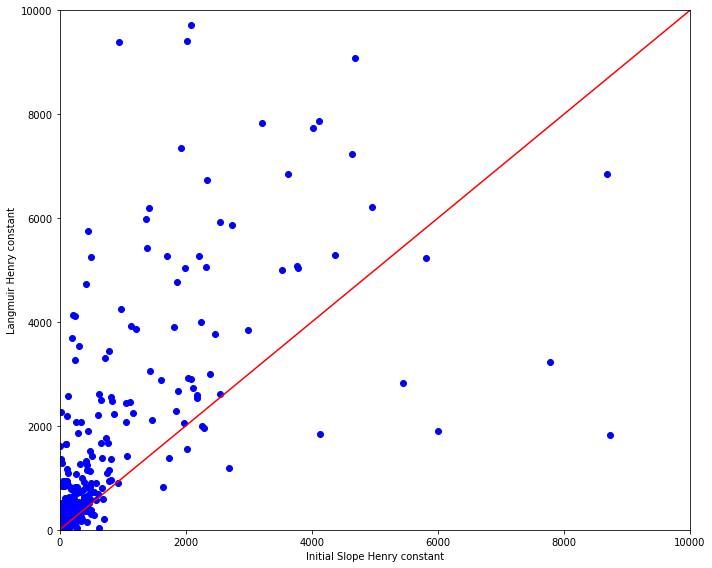

In [158]:
fig, ax = plt.subplots(figsize=(10,8))
slope_henries = henry_coeff_df_henry['henry_constant'].values
langmuir_henries = henry_coeff_df_langmuir['henry_constant'].values
for i in range(len(slope_henries)):
    if np.isnan(slope_henries[i]) or np.isnan(langmuir_henries[i]):
        continue
    ax.scatter(slope_henries[i], langmuir_henries[i], c='b')
ax.plot([0,1e11], [0, 1e11], c='r')
ax.set_xlim([0, 10000])
ax.set_ylim([0, 10000])
ax.set_xlabel('Initial Slope Henry constant')
ax.set_ylabel('Langmuir Henry constant')
plt.tight_layout()
plt.show()


#### Run this for adsorption isotherm graphs of the files that we were not able to determine a Henry coefficient

Number of messed up isotherms: 199
10.1021Jp074889i.Isotherm69


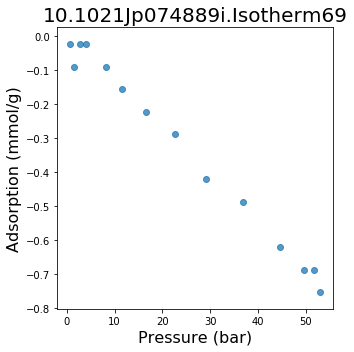

10.1016j.memsci.2011.09.040.Isotherm4


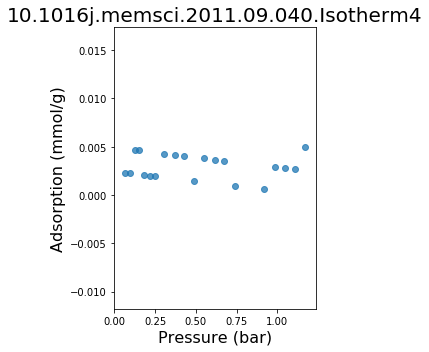

10.1021ic200937u.Isotherm5


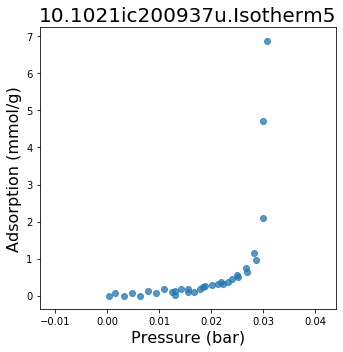

10.1016j.micromeso.2008.11.020.Isotherm3


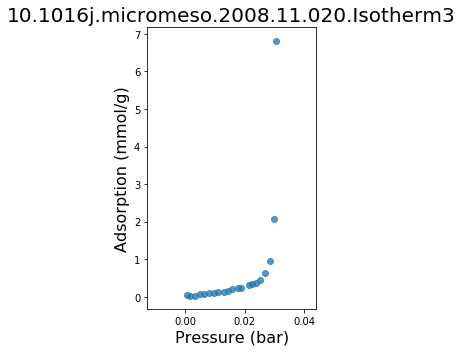

10.1007978-1-4613-1375-5_17.isotherm7


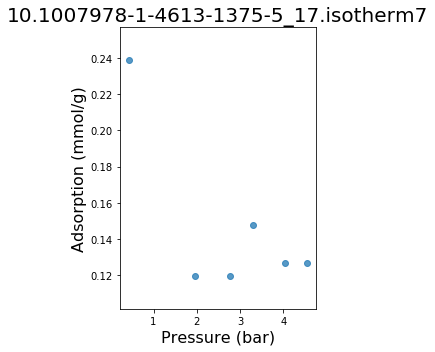

In [125]:
print('Number of messed up isotherms: {:d}'.format(len(messed_up_isotherms_langmuir)))
for messed_up_isotherm in messed_up_isotherms_langmuir[:5]:
    print(messed_up_isotherm)
    pressure, adsorption = read_isotherm_and_convert_units(messed_up_isotherm)
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.scatter(pressure, adsorption, marker='o', alpha=0.75)
    plt.xlabel('Pressure (bar)', fontsize=16)
    plt.ylabel('Adsorption (mmol/g)', fontsize=16)
    plt.title(messed_up_isotherm, fontsize=20)
    plt.tight_layout()
    plt.show()

In [146]:
def plot_isotherm_with_fits(filename, gas, material, outfile, not_save=True):
    try:
        #henry, rmse, n, n_del = find_optimal_henry(filename, 0.02)
        henry, rmse, srmse, n_del, M, K = find_optimal_henry_langmuir(filename)
        henry2, rmse2, n2, n_del2 = find_optimal_henry(filename, 0.005)
    except Exception as e:
        print(e)
        raise Exception('Oops! The isotherm was messed up!')
    
    pressure, adsorption = read_isotherm_and_convert_units(filename)
    new_p = np.linspace(0, pressure[-1], num=100)
    new_n = (M * K * new_p) / (1 + K * new_p)
    new_n2 = henry2 * new_p
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(pressure[:n_del], adsorption[:n_del], marker='x', color='k', zorder=999)
    ax.scatter(pressure[n_del:], adsorption[n_del:], label='Experimental Data', color='b', zorder=999)
    ax.plot([0, pressure[-1]], [0, pressure[-1] * henry], color='#911eb4', label='Langmuir-derived Henry Coefficient', lw=2)
    ax.plot(new_p, new_n, label='Langmuir Fit', color='green', lw=1.9, ls='--')
    #ax.plot(new_p, new_n2, label='Initial Slope Henry Coefficient', color='cyan', lw=1.9)
    plt.legend()
    plt.xlabel('Pressure [bar]')
    plt.ylabel('Adsorption [mmol/g]')
    plt.ylim([0, np.max(adsorption)*1.2])
    #plt.title('{} adsorption in {}: {}\nLangmuir-derived Henry Coeff: {:.2f} mmol/g-bar\nInitial Slope Henry Coeff: {:.2f} mmol/g-bar\nRMSE: {:.4f}\nsRMSE: {:.4f}\nK: {:.2f}, M: {:.2f}\nM/K: {:.2e}'.format(gas, material, filename, henry, henry2, rmse, srmse, K, M, M/K))
    plt.title('{} adsorption in {}'.format(gas, material))
    if srmse > 0.15:
        ax.set_facecolor((1.0, 0.47, 0.42))
    if not not_save:
        plt.savefig('pics/' + outfile + '_clean.png', dpi=300, format='png')
    plt.show()
    print('-----------------------------------------------------------')
    return

10.1021Ic4020256.Isotherm6


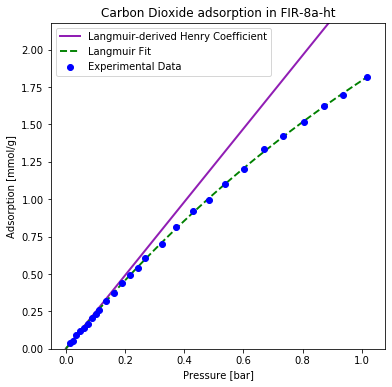

-----------------------------------------------------------
10.1002cssc.201200907.isotherm3


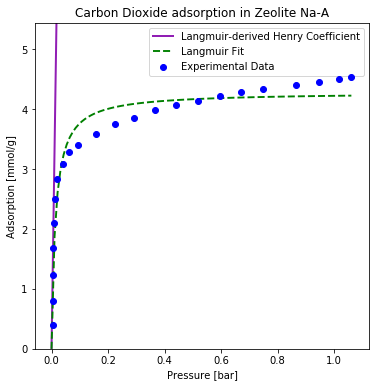

-----------------------------------------------------------
10.1016j.apenergy.2013.06.041.isotherm4


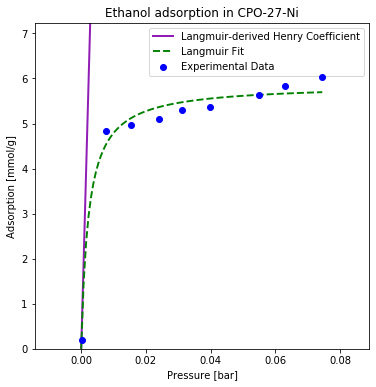

-----------------------------------------------------------
10.108008927020902988865.Isotherm4-1


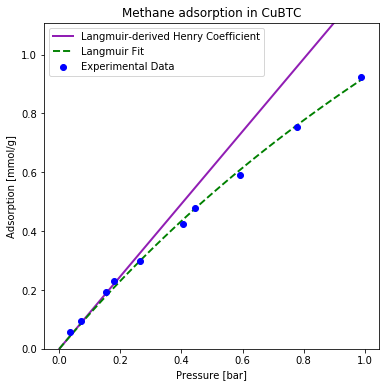

-----------------------------------------------------------
10.1016j.cej.2012.04.071.isotherm8


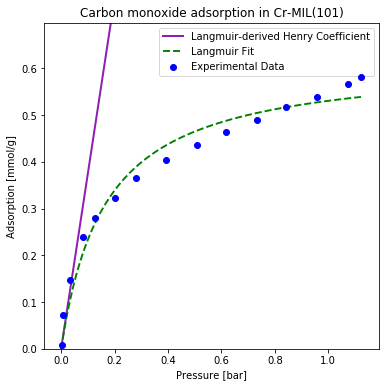

-----------------------------------------------------------
10.1039C2cp23839j.Isotherm75


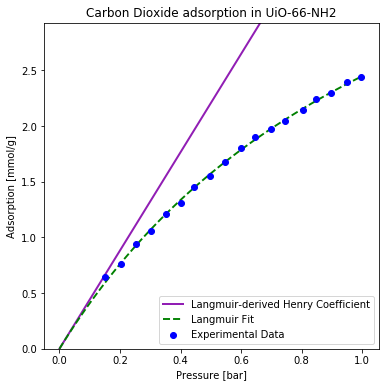

-----------------------------------------------------------
10.1021Jp7097153.Isotherm1


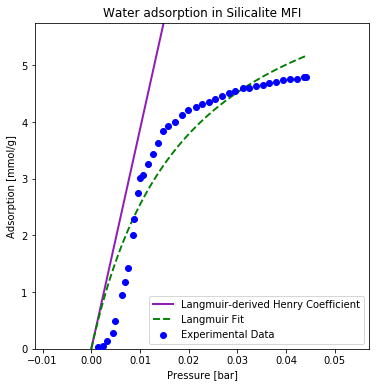

-----------------------------------------------------------
10.1039c4ta07115h.Isotherm3


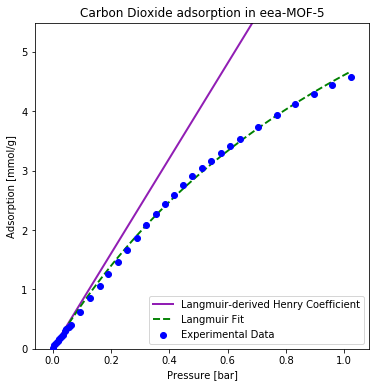

-----------------------------------------------------------
10.1039C1jm10264h.Isotherm76


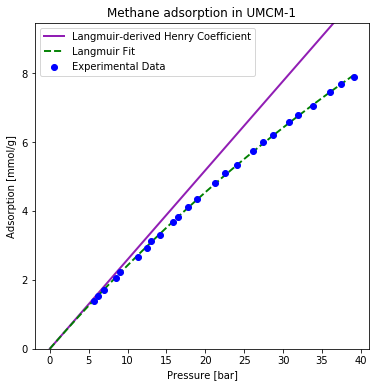

-----------------------------------------------------------
10.1021La803074g.isotherm3b


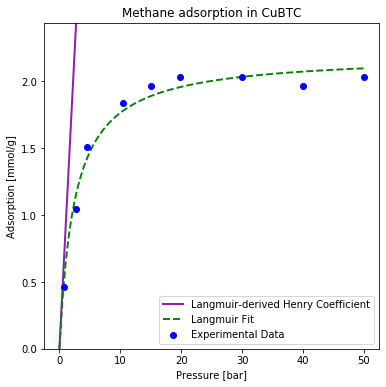

-----------------------------------------------------------


In [163]:
n = 10
for i in range(n):
    idx = random.choice(np.arange(len(henry_coeff_df_langmuir.index[henry_coeff_df_langmuir['ok']==True])))
    gas = henry_coeff_df_langmuir.iat[idx, 0]
    material = henry_coeff_df_langmuir.iat[idx, 2]

    filename = henry_coeff_df_langmuir.iat[idx, 5]
    print(filename)
    outfile = 'langmuir_fig_' + str(i)
    try:
        plot_isotherm_with_fits(filename, gas, material, outfile, False)
    except:
        print('what happened')
        continue

[3.1416, 0.0]


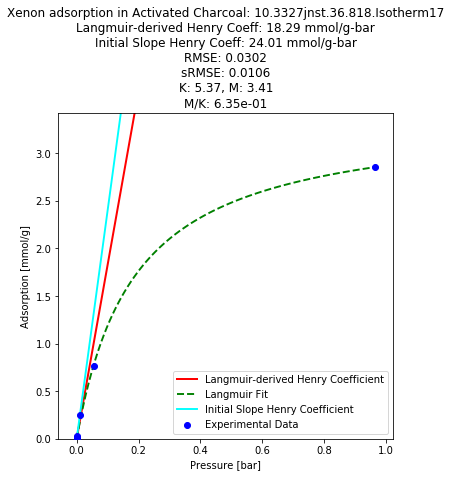

-----------------------------------------------------------
[1.2947000000000002, 0.0]


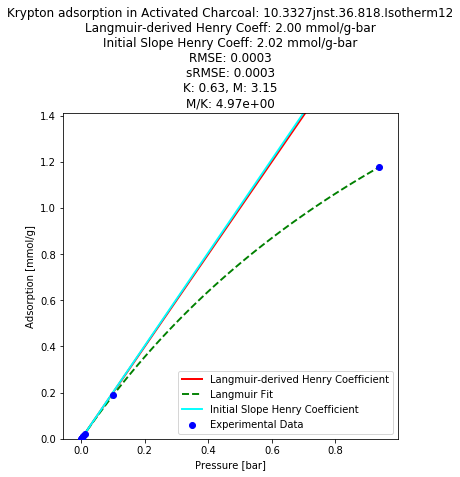

-----------------------------------------------------------
[2.690622, 73908560920114.39]


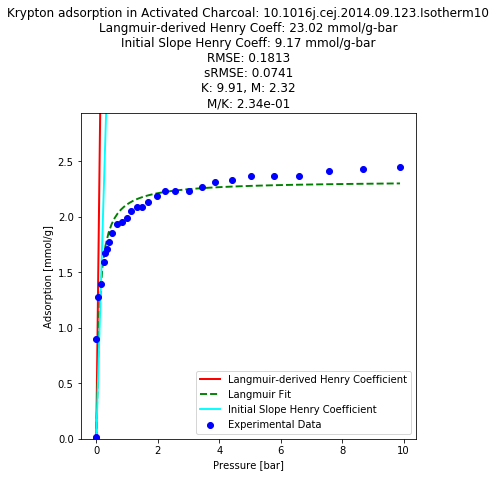

-----------------------------------------------------------


In [128]:
plot_isotherm_with_fits('10.3327jnst.36.818.Isotherm17', 'Xenon', 'Activated Charcoal', 'asdf')
plot_isotherm_with_fits('10.3327jnst.36.818.Isotherm12', 'Krypton', 'Activated Charcoal', 'asdf')
plot_isotherm_with_fits('10.1016j.cej.2014.09.123.Isotherm10', 'Krypton', 'Activated Charcoal', 'asdf')

### Lets try analyzing the Henry Coefficients and get rid of outliers

In [129]:
def z_score_detection(henry_coeff_df, z_threshold, exclude_z_bool=False):
    new_df = pd.DataFrame(columns=['z_score', 'z_bool'])
    for gas in henry_coeff_df.gas.unique():
        if not exclude_z_bool:
            henries = henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True]['henry_constant'].values
        else:
            henries = henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['z_bool'] == True]['henry_constant'].values
        mean_henry = np.nanmean(henries)
        stdev_henry = np.nanstd(henries)
        z_scores = [(henry - mean_henry) / stdev_henry for henry in henries]
        if not exclude_z_bool:
            temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True].index,
                                   data={'z_score': z_scores, 'z_bool': np.less(np.abs(z_scores), z_threshold)})
        else:
            temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['z_bool'] == True].index,
                                   data={'z_score': z_scores, 'z_bool': np.less(np.abs(z_scores), z_threshold)})
        new_df = pd.concat([new_df, temp_df], sort=False)
    if 'z_score' in henry_coeff_df.columns:
        del henry_coeff_df['z_score']
    if 'z_bool' in henry_coeff_df.columns:
        del henry_coeff_df['z_bool']
    
    henry_coeff_df = henry_coeff_df.join(new_df, how='left')
    henry_coeff_df['z_bool'].fillna(False, inplace=True)
    return henry_coeff_df
henry_coeff_df_langmuir = z_score_detection(henry_coeff_df_langmuir, 3.0)
henry_coeff_df_langmuir = z_score_detection(henry_coeff_df_langmuir, 3.0, True)
henry_coeff_df_henry = z_score_detection(henry_coeff_df_henry, 3.0)
henry_coeff_df_henry = z_score_detection(henry_coeff_df_henry, 3.0, True)
#henry_coeff_df = z_score_detection(henry_coeff_df, 1.5, True)

In [130]:
henry_coeff_df_langmuir.loc[henry_coeff_df_langmuir.z_bool == True].sort_values(by='henry_constant', ascending=False).head(20)

,gas,inchikey,material,hashkey,henry_constant,filename,ok,z_score,z_bool
1662,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,155232.579755,10.1021Jp1033273.Isotherm16,True,2.231524,True
2741,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Zeolite 4A,NIST-MATDB-081a0818678716f502aee0b58ac1b30a,148191.524210,10.1021Jp805923k.Isotherm3-1,True,2.116264,True
1427,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Zeolite Na-A,NIST-MATDB-9ee35322ac5ddba224d845a03c651b29,130161.825246,10.1252Jcej.37.67.isotherm4,True,1.821121,True
2733,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Zeolite 4A,NIST-MATDB-081a0818678716f502aee0b58ac1b30a,117098.194357,10.1021Jp805923k.Isotherm2-2,True,2.289688,True
2075,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Mg-MOF-74,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,101779.361148,10.1021Ct500094w.Isotherm6,True,1.938089,True
2219,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,CPO-27-Ni,NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28,93688.212962,10.1039C4cs00078a.Isotherm3,True,1.752381,True
225,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Zeolite 5A,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,92469.050306,10.1021Je800900a.Isotherm53,True,1.724398,True
1620,Toluene,YXFVVABEGXRONW-UHFFFAOYSA-N,Activated Carbon,NIST-MATDB-b2cbe7a27aa1570f2ff2c04b82289f25,77987.748420,10.1021la010232r.Isotherm6,True,2.827035,True
2066,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Mg-MOF-74,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,65786.296856,10.1021Jp503778m.Isotherm7,True,1.111975,True
2220,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,CPO-27-Ni,NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28,63836.851552,10.1039C2dt31112g.Isotherm10,True,1.067231,True


In [131]:
henry_coeff_df_langmuir['log_henry'] = np.log10(henry_coeff_df_langmuir['henry_constant'])
henry_coeff_df_langmuir['mybool'] = henry_coeff_df_langmuir['log_henry'] > -5
henry_coeff_df_henry['log_henry'] = np.log10(henry_coeff_df_henry['henry_constant'])
henry_coeff_df_henry['mybool'] = henry_coeff_df_henry['log_henry'] > -5

/home/sturlusa/my_projects/Environments/autoencoder37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
henry_coeff_df_langmuir.sort_values(by='mybool', ascending=True).head(10)

,gas,inchikey,material,hashkey,henry_constant,filename,ok,z_score,z_bool,log_henry,mybool
2338,Hydrogen,UFHFLCQGNIYNRP-UHFFFAOYSA-N,Zn3(TCPB)2(H2O)2,NIST-MATDB-50f70ae705dac74976f4c6867d15233c,NaN,10.1039C3dt50896j.isotherm5,False,NaN,False,NaN,False
1266,Hydrogen,UFHFLCQGNIYNRP-UHFFFAOYSA-N,IRMOF-1,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,NaN,10.1021Jp305524f.Isotherm100,False,NaN,False,NaN,False
1277,Hydrogen,UFHFLCQGNIYNRP-UHFFFAOYSA-N,IRMOF-1,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,NaN,10.1021Jp074889i.Isotherm27,False,NaN,False,NaN,False
1905,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,MCM-41,NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd,NaN,10.1021acs.jpcc.5b06660.Isotherm5,False,NaN,False,NaN,False
1904,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,MCM-41,NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd,NaN,10.1039C4cs00078a.Isotherm1,False,NaN,False,NaN,False
2756,Hydrogen,UFHFLCQGNIYNRP-UHFFFAOYSA-N,MOF-74,NIST-MATDB-49b1e69854030020562c1a51b5d17de8,NaN,10.1021Jp809539w.isotherm20,False,NaN,False,NaN,False
2770,N-Butane,IJDNQMDRQITEOD-UHFFFAOYSA-N,UiO-66(Zr),NIST-MATDB-27ce47f74d79f611f6d3f9caa686697b,NaN,10.1021Jp509672c.Isotherm8,False,NaN,False,NaN,False
2771,N-Butane,IJDNQMDRQITEOD-UHFFFAOYSA-N,UiO-66(Zr),NIST-MATDB-27ce47f74d79f611f6d3f9caa686697b,NaN,10.1021Jp509672c.Isotherm7,False,NaN,False,NaN,False
1243,Hydrogen,UFHFLCQGNIYNRP-UHFFFAOYSA-N,IRMOF-1,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,NaN,10.1021Jp305524f.Isotherm73,False,NaN,False,NaN,False
1880,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,MCM-41,NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd,NaN,10.1016j.egypro.2013.05.098.Isotherm3,False,NaN,False,NaN,False


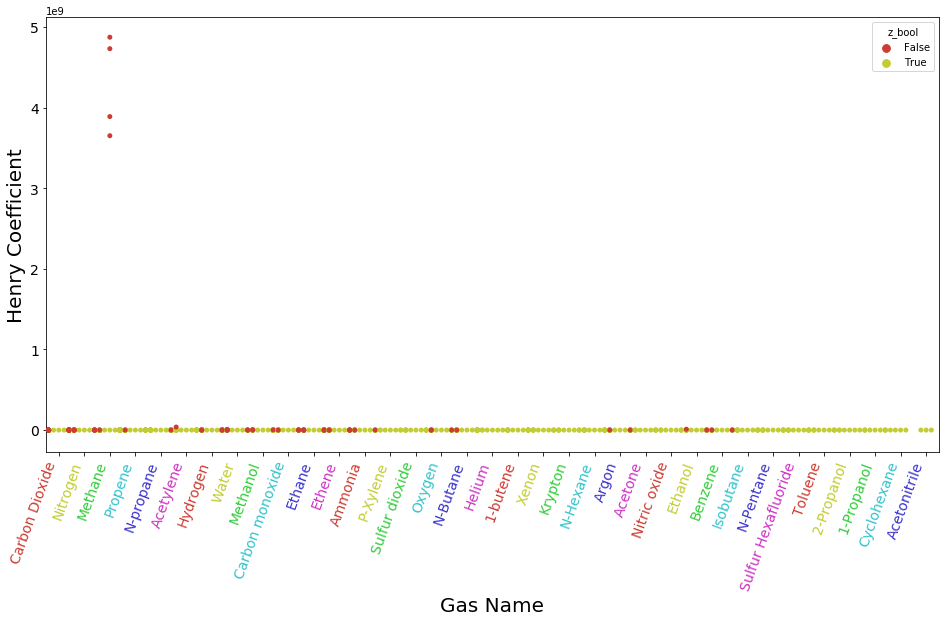

In [133]:
fig = plt.figure(figsize=(16,8))
pal = sns.hls_palette(6, l=.5, s=.6)
sp = sns.swarmplot(x='gas', y='henry_constant', hue="z_bool", palette=pal, data=henry_coeff_df_langmuir)
#plt.ylim([-1, 50000])
ax = plt.gca()
#ax.get_legend().remove()
plt.xticks(rotation=70, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Henry Coefficient', fontsize=20)
plt.xlabel('Gas Name', fontsize=20)
pal.as_hex()
n = len(pal)
for (i, xtick) in enumerate(ax.get_xticklabels()):
    xtick.set_color(pal[i%n])

In [134]:
def construct_henry_matrix(henry_coeff_df, method_for_multiple_isotherms, use_all=False):
    assert method_for_multiple_isotherms in ['median', 'mean']
    henry_matrix = np.empty(material_gas_df.shape)
    henry_matrix.fill(np.nan)

    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            ok_isotherms = henry_coeff_df.loc[(henry_coeff_df['inchikey'] == gas.split('_')[0]) & (henry_coeff_df['hashkey'] == material) & (henry_coeff_df['mybool'] == True)]
            if len(ok_isotherms['mybool'].values) != 0 or use_all:
                if method_for_multiple_isotherms == 'mean':
                    henry_matrix[i, j] = np.mean(ok_isotherms['henry_constant'].values)
                elif method_for_multiple_isotherms == 'median':
                    henry_matrix[i, j] = np.median(ok_isotherms['henry_constant'].values)
    return henry_matrix

henry_matrix_langmuir = construct_henry_matrix(henry_coeff_df_langmuir, 'median', use_all=False)
henry_matrix_henry = construct_henry_matrix(henry_coeff_df_henry, 'median', use_all=False)

In [135]:
def prune_matrix(henry_matrix, min_data_points, verbose=True):
    keep_row = np.ones(henry_matrix.shape[0], dtype=bool)
    keep_column = np.ones(henry_matrix.shape[1], dtype=bool)
    nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
    gases_cut = 0
    materials_cut = 0
    count = 0

    while True:
        for i_row in range(henry_matrix.shape[0]):
            if np.count_nonzero(~np.isnan(henry_matrix[i_row, keep_column])) < min_data_points:
                keep_row[i_row] = False

        for i_column in range(henry_matrix.shape[1]):
            if np.count_nonzero(~np.isnan(henry_matrix[keep_row, i_column])) < min_data_points:
                keep_column[i_column] = False

        if nb_kept_rows_and_columns == (np.sum(keep_row) + np.sum(keep_column)):
            break

        nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
        count += 1

    materials_cut = np.sum(~keep_row)
    gases_cut = np.sum(~keep_column)

    if verbose:
        print("Number of materials cut: {}" .format(materials_cut))
        print("Number of gases cut: {}" .format(gases_cut))
        print('The remaining dimensions of the matrix are {} by {}'.format(henry_matrix.shape[0]-materials_cut,henry_matrix.shape[1]-gases_cut))
        print('The number of iterations of sparsing the matrix: {}'.format(count))
        print('The sparsity of the resulting matrix is {:.1f}%'.format(
            100*np.count_nonzero(np.isnan(henry_matrix[keep_row, :][:, keep_column]))/np.size(henry_matrix[keep_row, :][:, keep_column])))
    
    return keep_row, keep_column

keep_row_h, keep_column_h = prune_matrix(henry_matrix_henry, 5)
new_henry_matrix_h = henry_matrix_henry[keep_row_h, :][:, keep_column_h]

keep_row_l, keep_column_l = prune_matrix(henry_matrix_langmuir, 5)
new_henry_matrix_l = henry_matrix_langmuir[keep_row_l, :][:, keep_column_l]

Number of materials cut: 5
Number of gases cut: 1
The remaining dimensions of the matrix are 108 by 34
The number of iterations of sparsing the matrix: 1
The sparsity of the resulting matrix is 79.3%
Number of materials cut: 12
Number of gases cut: 3
The remaining dimensions of the matrix are 101 by 32
The number of iterations of sparsing the matrix: 1
The sparsity of the resulting matrix is 78.2%


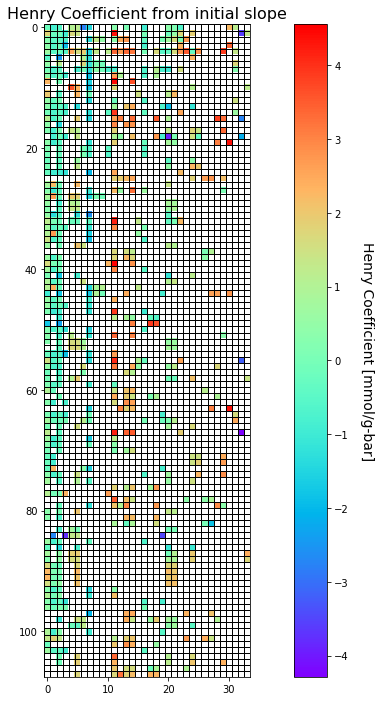

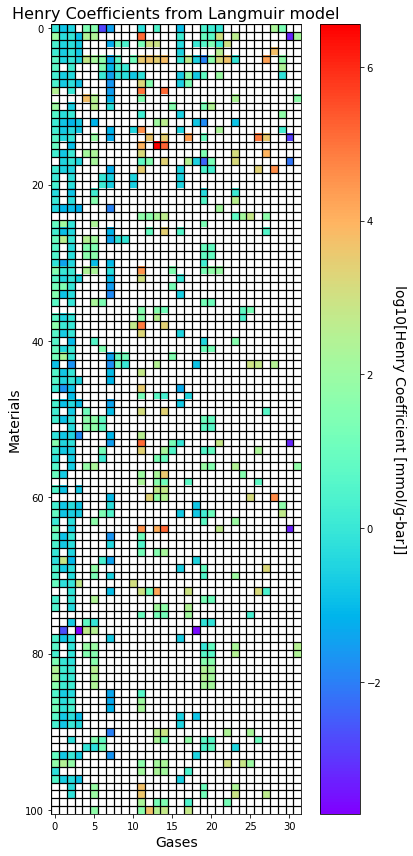

In [154]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
for y in range(new_henry_matrix_h.shape[0]):
    plt.plot([0-0.5, new_henry_matrix_h.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1, color='k')
for x in range(new_henry_matrix_h.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, new_henry_matrix_h.shape[0]-0.5], linewidth=1, color='k')
plt.imshow(np.log10(new_henry_matrix_h), interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
ax.set_title('Henry Coefficient from initial slope', fontsize=16)
plt.show()

fig = plt.figure(figsize=(6,12))
ax = plt.gca()
for y in range(new_henry_matrix_l.shape[0]):
    plt.plot([0-0.5, new_henry_matrix_l.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(new_henry_matrix_l.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, new_henry_matrix_l.shape[0]-0.5], linewidth=1.25, color='k')
plt.imshow(np.log10(new_henry_matrix_l), interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('log10[Henry Coefficient [mmol/g-bar]]', fontsize=14, rotation=270, labelpad=25)
ax.set_title('Henry Coefficients from Langmuir model', fontsize=16)
ax.set_xlabel('Gases', fontsize=14)
ax.set_ylabel('Materials', fontsize=14)
plt.tight_layout()
plt.savefig('pics/HenryMatrix_langmuir_model.png', dpi=300, format='png')
plt.show()

In [137]:
mof = 23
gas = 1
new_henry_matrix_l[mof, gas]
print(material_gas_df.index.values[keep_row_l][mof])
print(material_gas_df.columns.values[keep_column_l][gas])
material_gas_to_filename[material_gas_df.columns.values[keep_column_l][gas]][material_gas_df.index.values[keep_row_l][mof]]

NIST-MATDB-2f391b46b4e3f7747db4ad7bba0ccbfd
IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K


['10.1021acs.langmuir.6b02814.Isotherm8',
 '10.1016j.ces.2009.05.039.isotherm4',
 '10.1016j.ces.2009.05.039.Isotherm17',
 '10.1016j.ces.2009.05.039.isotherm13',
 '10.1016j.ces.2009.05.039.isotherm12',
 '10.1016j.ces.2009.05.039.isotherm11']

In [164]:
henry_matrix_df = pd.DataFrame(data=np.array(new_henry_matrix_h),
                                 columns=[material_gas_df.columns[i] for i in np.arange(material_gas_df.shape[1])[keep_column_h]],
                                 index=[material_gas_df.index[i] for i in np.arange(material_gas_df.shape[0])[keep_row_h]],
                                dtype=float)

henry_matrix_df.to_csv('data/henry_matrix_df_h_5.csv')

henry_matrix_df = pd.DataFrame(data=np.array(new_henry_matrix_l),
                                 columns=[material_gas_df.columns[i] for i in np.arange(material_gas_df.shape[1])[keep_column_l]],
                                 index=[material_gas_df.index[i] for i in np.arange(material_gas_df.shape[0])[keep_row_l]],
                                dtype=float)

henry_matrix_df.to_csv('data/henry_matrix_df_l_5.csv')